<a href="https://colab.research.google.com/github/yonbrand/Gait-Recognition/blob/main/gait_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gait Segmentation
This code aims to take an acceleration raw data from daily-living, and extract the gait (walking) segmentation during the recording period.
This code is based on the original paper code: https://github.com/qinnzou/Gait-Recognition-Using-Smartphones/blob/master/code/gait-extraction/tf_seg_new.ipynb

Converted from TensorFlow to Pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os 
import numpy as np
import pandas as pd
from numpy import genfromtxt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import pickle

from sklearn.model_selection import train_test_split


cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load the data

In [9]:
def read_data(data_path,alpha):
  file_names = os.listdir(data_path)
  all_data=np.empty((0,1,3,1024))
  for ind in file_names:
    curr_file=str(data_path+'/'+ind)
    df=pd.read_csv(curr_file, header=None)
    if data_path==HC_path:
      df=pd.read_csv(curr_file)
      df=df.iloc[:,2:] #the Healty control (HC) dataset includes 5 columns but we need only 3 columns (3 acceleration axes)
    df=df.iloc[:int(np.floor(alpha*len(df))),:] #there is a plenty of data, which make it hard to use google colab RAM. Therefore we took 20% of the data from each participant
    data_np = np.array(df)
    n_counts = 1024
    data_n=data_np[0:((len(data_np)//n_counts)*n_counts)] #remove part of the data for dividing without residual
    sample_data=data_n.reshape((len(data_n)//n_counts),1,3,n_counts) #divide the data to samples in length of 1024
    all_data=np.append(all_data,sample_data,axis=0)    
  return all_data


def read_labels(label_path,alpha):
  file_names = os.listdir(label_path)
  all_labels=np.empty((0,1024))
  for ind in file_names:
    curr_file=str(label_path+'/'+ind)
    df=pd.read_csv(curr_file, header=None)
    df=df.iloc[:int(np.floor(alpha*len(df))),:]
    labels_np = np.array(df)
    labels_n=labels_np[0:((len(labels_np)//1024)*1024)]
    sample_labels=labels_n.reshape((len(labels_n)//1024),1024)
    all_labels=np.append(all_labels,sample_labels,axis=0) 
  return all_labels

In [4]:
main_path='/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/'

In [5]:
train_data_path='/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/Data PD/Data'
train_label_path='/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/Data PD/labels'

In [6]:
os.path.isdir(train_data_path)


True

In [7]:
HC_path='/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/Data Healthy'

In [10]:
data = read_data(train_data_path,0.2) 
#with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/data_seg.npy', 'wb') as f:
#    pickle.dump(data, f, protocol=4)

In [11]:
labels = read_labels(train_label_path,0.2) 
#with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/labels_seg.npy', 'wb') as f:
#    pickle.dump(labels, f, protocol=4)

In [ ]:
data_pickle = open ("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/data_seg.npy", "rb")
data = pickle.load(data_pickle)

In [ ]:
labels_pickle = open ("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/labels_seg.npy", "rb")
labels = pickle.load(labels_pickle)

In [12]:
#split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(data[:int(np.floor(0.3*data.shape[0]))], labels[:int(np.floor(0.3*labels.shape[0]))], test_size=0.33) #here we also reduce the number of samples for running time and memory reasons

Network Architecture

In [13]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=[1,16])
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,16])

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=[1,16])
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=[1,16])

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=[1,16])
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=[1,16])

        self.convTranspose1 = nn.ConvTranspose2d(256, 128, (1, 2), stride=(1, 2))
        self.conv2_5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=[1,16])
        self.conv2_6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=[1,16])

        self.convTranspose2 = nn.ConvTranspose2d(128, 64, (1, 2), stride=(1, 2))
        self.conv1_4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=[1,16])
        self.conv1_4_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,16])
        self.conv1_5 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=[3,1])
        self.conv1_6 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)

  # define forward function
    def forward(self, x):
        pad_x = nn.ReflectionPad2d((7, 8, 0, 0))(x)

        conv1_1 = F.relu( self.conv1_1(pad_x) )
        conv1_1 = nn.ReflectionPad2d((7, 8, 0, 0))(conv1_1)
        conv1_2 = F.relu( self.conv1_2(conv1_1) )

        conv2_1 = nn.MaxPool2d(kernel_size=[1,2], stride=[1,2])(conv1_2)

        conv2_1 = nn.ReflectionPad2d((7, 8, 0, 0 ))(conv2_1)
        conv2_2 = F.relu( self.conv2_1(conv2_1) )
        conv2_2 = nn.ReflectionPad2d((7, 8, 0, 0 ))(conv2_2)
        conv2_3 = F.relu( self.conv2_2(conv2_2) )

        conv3_1 = nn.MaxPool2d(kernel_size=[1,2], stride=[1,2])(conv2_3)

        conv3_1 = nn.ReflectionPad2d((7, 8, 0, 0))(conv3_1)
        conv3_2 = F.relu( self.conv3_1(conv3_1) )
        conv3_2 = nn.ReflectionPad2d((7, 8, 0, 0))(conv3_2)
        conv3_3 = F.relu( self.conv3_2(conv3_2) )
        conv3_3 = nn.ReflectionPad2d((7, 8, 0, 0))(conv3_3)
        conv3_4 = F.relu( self.conv3_2(conv3_3) )

        conv2_4_1 = self.convTranspose1(conv3_4)
        conv2_4 = torch.cat((conv2_4_1, conv2_3), 1)
        conv2_4 = nn.ReflectionPad2d((7, 8, 0, 0))(conv2_4)
        conv2_5 = F.relu( self.conv2_5(conv2_4) )
        conv2_5 = nn.ReflectionPad2d((7, 8, 0, 0))(conv2_5)
        conv2_6 = F.relu( self.conv2_6(conv2_5) )

        conv1_3_1 = self.convTranspose2(conv2_6)
        conv1_3 = torch.cat((conv1_2, conv1_3_1), 1)
        conv1_3 = nn.ReflectionPad2d((7, 8, 0, 0))(conv1_3)
        conv1_4 = F.relu( self.conv1_4(conv1_3) )
        conv1_4 = nn.ReflectionPad2d((7, 8, 0, 0))(conv1_4)
        conv1_4 = F.relu( self.conv1_4_2(conv1_4) )
        conv1_5 = F.relu( self.conv1_5(conv1_4) )
        conv1_6 = torch.sigmoid( self.conv1_6(conv1_5) )

        out = torch.reshape(conv1_6, (-1, 1024))

        return out

In [15]:
# Training Parameters
learning_rate = 0.00001
num_steps =30
batch_size = 32 
display_step = 1
criterion = nn.BCELoss()
data_len = len(X_train)

In [16]:
tensor_x_train = torch.Tensor(X_train).float().to(device) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train).float().to(device)

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # create your dataloader


tensor_x_test = torch.Tensor(X_test).float().to(device) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test).float().to(device)

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset) # create your dataloader



In [17]:
print(tensor_x_train.shape)
print(tensor_y_train.shape)
print(tensor_x_test.shape)
print(tensor_y_test.shape)


torch.Size([3893, 1, 3, 1024])
torch.Size([3893, 1024])
torch.Size([1918, 1, 3, 1024])
torch.Size([1918, 1024])


In [18]:
model = Network().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
def my_loss(y_,output_map):
  t0 = y_*torch.log(torch.clamp(output_map,1e-10,1.0))
  t1 = (1-y_)*torch.log(torch.clamp(1-output_map,1e-10,1.0))
  return -torch.mean( t0 + t1)
  #return -torch.mean( y_*torch.log(torch.clamp(output_map,1e-10,1.0)) +(1-y_)*torch.log(torch.clamp(1-output_map,1e-10,1.0)))

In [20]:
def check_acc(model, loader):
    correct = 0
    total = 0
    #TP=0
    #TN=0
    #FP=0
    #FN=0
    with torch.no_grad():
        for data in loader:
            features, labels = data
            outputs = model(features)
            predicted = torch.round(outputs)
            total += (labels.size(0)*labels.size(1))
            correct += torch.sum(predicted==labels)
            #TP+= ((predicted == labels) & (labels==1)).sum().item()
            #TN+=((predicted == labels) & (labels==0)).sum().item()
            #FP+=((predicted != labels) & (labels==0)).sum().item()
            #FN+=((predicted != labels) & (labels==1)).sum().item()
            
    acc = (100 * correct / total)
    #precision=100*(TP/(1+TP+FP))
    #sensitivity=100*(TP/(1+TP+FN))
    #specificity=100*(TN/(1+TN+FP))
    if loader=='train_dataloader':
      print('Accuracy on the training set is : %.3f %%' % acc)
    elif loader=='test_dataloader':
      print('Accuracy on the validation set is: %.3f %%' % acc)
    
    return acc

# Train the model

In [ ]:
all_train_loss = []
all_test_loss = []
train_acc=[]
validation_acc=[]
train_preds=[]


for epoch in range(num_steps):
      
  model.train()
  for batch_idx, (data, labels) in enumerate(train_dataloader):
    
    preds = model(data)
    train_preds.append(preds)

    #loss = criterion(preds, labels.to(device))
    loss = my_loss(labels, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    bach_loss = loss.item()

    if batch_idx % 100 == 0:
      print('[%d, %5d] loss: %.3f' %(epoch, batch_idx, bach_loss))

  all_train_loss.append(float(bach_loss))
  model.eval()
  
  #test_preds = model(tensor_x_test)
  #test_loss = my_loss(tensor_y_test, test_preds)
  #all_test_loss.append(float(test_loss))

  #print("epoch %d,  train loss : %.3f, test loss : %.3f" % (epoch, bach_loss, test_loss))  
  print("epoch %d,  train loss : %.3f," % (epoch, bach_loss))  


  train_acc.append( check_acc(model, train_dataloader) )
  validation_acc.append( check_acc(model, test_dataloader) )
  with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/train_acc.npy', 'wb') as f:
    pickle.dump(train_acc, f, protocol=4)
  with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/validation_acc.npy', 'wb') as f:
    pickle.dump(validation_acc, f, protocol=4)
     

[0,     0] loss: 0.690
[0,   100] loss: 0.256
epoch 0,  train loss : 0.285,
[1,     0] loss: 0.402
[1,   100] loss: 0.308
epoch 1,  train loss : 0.326,
[2,     0] loss: 0.308
[2,   100] loss: 0.267
epoch 2,  train loss : 0.325,
[3,     0] loss: 0.176
[3,   100] loss: 0.308
epoch 3,  train loss : 0.337,
[4,     0] loss: 0.264
[4,   100] loss: 0.316
epoch 4,  train loss : 0.413,
[5,     0] loss: 0.340
[5,   100] loss: 0.314
epoch 5,  train loss : 0.434,
[6,     0] loss: 0.443
[6,   100] loss: 0.274
epoch 6,  train loss : 0.309,
[7,     0] loss: 0.337
[7,   100] loss: 0.228
epoch 7,  train loss : 0.362,
[8,     0] loss: 0.252
[8,   100] loss: 0.457
epoch 8,  train loss : 0.171,
[9,     0] loss: 0.234
[9,   100] loss: 0.357
epoch 9,  train loss : 0.154,
[10,     0] loss: 0.493
[10,   100] loss: 0.355
epoch 10,  train loss : 0.231,
[11,     0] loss: 0.247
[11,   100] loss: 0.386
epoch 11,  train loss : 0.317,
[12,     0] loss: 0.381
[12,   100] loss: 0.313
epoch 12,  train loss : 0.296,
[13

In [ ]:
torch.save(model.state_dict(), main_path+ 'gait_segmentation_'+ str(epoch) +'.pt') #saving the trained model

In [ ]:
train_acc_pickle = open ("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/train_acc.npy", "rb")
train_acc = pickle.load(train_acc_pickle)

validation_acc_pickle = open ("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/validation_acc.npy", "rb")
validation_acc = pickle.load(validation_acc_pickle)

Text(0, 0.5, 'accuracy')

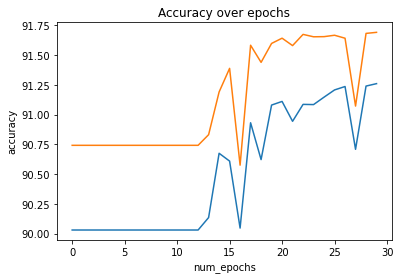

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_acc)),train_acc)
plt.plot(range(len(train_acc)),validation_acc)
plt.title('Accuracy over epochs')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')


Text(0, 0.5, 'loss')

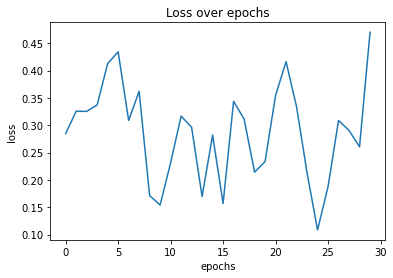

In [ ]:
plt.plot(all_train_loss)
plt.title('Loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

change batch size to 64

In [21]:
# Training Parameters
learning_rate = 0.00001
num_steps =30
batch_size = 64
display_step = 1
criterion = nn.BCELoss()
data_len = len(X_train)

In [22]:
tensor_x_train = torch.Tensor(X_train).float().to(device) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train).float().to(device)

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # create your dataloader


tensor_x_test = torch.Tensor(X_test).float().to(device) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test).float().to(device)

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset) # create your dataloader



In [23]:
model = Network().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
all_train_loss2 = []
all_test_loss2 = []
train_acc2=[]
validation_acc2=[]
train_preds2=[]


for epoch in range(num_steps):
      
  model.train()
  for batch_idx, (data, labels) in enumerate(train_dataloader):
    
    preds = model(data)
    train_preds2.append(preds)

    #loss = criterion(preds, labels.to(device))
    loss = my_loss(labels, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    bach_loss = loss.item()

    if batch_idx % 100 == 0:
      print('[%d, %5d] loss: %.3f' %(epoch, batch_idx, bach_loss))

  all_train_loss2.append(float(bach_loss))
  model.eval()
  
  #test_preds = model(tensor_x_test)
  #test_loss = my_loss(tensor_y_test, test_preds)
  #all_test_loss.append(float(test_loss))

  #print("epoch %d,  train loss : %.3f, test loss : %.3f" % (epoch, bach_loss, test_loss))  
  print("epoch %d,  train loss : %.3f," % (epoch, bach_loss))  


  train_acc2.append( check_acc(model, train_dataloader) )
  validation_acc2.append( check_acc(model, test_dataloader) )
  with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/train_acc2.npy', 'wb') as f:
    pickle.dump(train_acc2, f, protocol=4)
  with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/validation_acc2.npy', 'wb') as f:
    pickle.dump(validation_acc2, f, protocol=4)
     

[0,     0] loss: 0.449
epoch 0,  train loss : 0.371,
[1,     0] loss: 0.288
epoch 1,  train loss : 0.313,
[2,     0] loss: 0.381
epoch 2,  train loss : 0.222,
[3,     0] loss: 0.373
epoch 3,  train loss : 0.537,
[4,     0] loss: 0.342
epoch 4,  train loss : 0.222,
[5,     0] loss: 0.266
epoch 5,  train loss : 0.513,
[6,     0] loss: 0.307
epoch 6,  train loss : 0.260,
[7,     0] loss: 0.310
epoch 7,  train loss : 0.254,
[8,     0] loss: 0.265
epoch 8,  train loss : 0.291,
[9,     0] loss: 0.421
epoch 9,  train loss : 0.332,
[10,     0] loss: 0.212
epoch 10,  train loss : 0.264,
[11,     0] loss: 0.303
epoch 11,  train loss : 0.261,
[12,     0] loss: 0.282
epoch 12,  train loss : 0.325,
[13,     0] loss: 0.323
epoch 13,  train loss : 0.330,
[14,     0] loss: 0.239
epoch 14,  train loss : 0.301,
[15,     0] loss: 0.234
epoch 15,  train loss : 0.359,
[16,     0] loss: 0.314
epoch 16,  train loss : 0.345,
[17,     0] loss: 0.289
epoch 17,  train loss : 0.295,
[18,     0] loss: 0.297
epoch 

In [26]:
torch.save(model.state_dict(), main_path+ 'gait_segmentation_batch64.pt') #saving the trained model

In [27]:
train_acc_pickle2 = open ("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/train_acc2.npy", "rb")
train_acc2 = pickle.load(train_acc_pickle2)

validation_acc_pickle2 = open ("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/validation_acc2.npy", "rb")
validation_acc2 = pickle.load(validation_acc_pickle2)

Text(0, 0.5, 'accuracy')

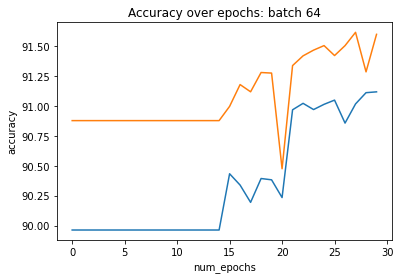

In [30]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_acc2)),train_acc2)
plt.plot(range(len(train_acc2)),validation_acc2)
plt.title('Accuracy over epochs: batch 64')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')


Text(0, 0.5, 'loss')

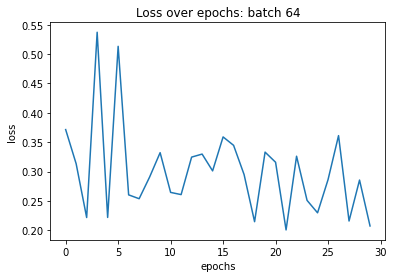

In [31]:
plt.plot(all_train_loss2)
plt.title('Loss over epochs: batch 64')
plt.xlabel('epochs')
plt.ylabel('loss')

# Load trained model

In [ ]:
from google.colab import files 
uploaded = files.upload() #upload the trained models files


Saving gait_segmentation.pt to gait_segmentation.pt


In [ ]:
#load one of the models
model=Network().to(device)
model.load_state_dict(torch.load('gait_segmentation.pt')) #load the corresponding model
model.to(device)

Network(
  (conv1_1): Conv2d(1, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(1, 16), stride=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(1, 16), stride=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(1, 16), stride=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(1, 16), stride=(1, 1))
  (convTranspose1): ConvTranspose2d(256, 128, kernel_size=(1, 2), stride=(1, 2))
  (conv2_5): Conv2d(256, 128, kernel_size=(1, 16), stride=(1, 1))
  (conv2_6): Conv2d(128, 128, kernel_size=(1, 16), stride=(1, 1))
  (convTranspose2): ConvTranspose2d(128, 64, kernel_size=(1, 2), stride=(1, 2))
  (conv1_4): Conv2d(128, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv1_4_2): Conv2d(64, 64, kernel_size=(1, 16), stride=(1, 1))
  (conv1_5): Conv2d(64, 256, kernel_size=(6, 1), stride=(1, 1))
  (conv1_6): Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
)

Extracting gait segments from the HC dataset

In [ ]:
data_HC = read_data(HC_path,0.01) 
with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/data_hc.npy', 'wb') as f:
    pickle.dump(data_HC, f, protocol=4)

In [ ]:
data_pickle_hc = open ("/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/data_hc.npy", "rb")
data_hc = pickle.load(data_pickle_hc)

In [ ]:
data_pd=X_test

In [ ]:
print(data_hc.shape)
print(data_pd.shape)

^ the data is balance between the 2 dataset

In [ ]:
tensor_hc = torch.Tensor(data_hc).float().to(device) # transform to torch tensor
tensor_pd= torch.Tensor(data_pd).float().to(device)

In [ ]:
hc_dataset = TensorDataset(tensor_hc,torch.zeros((tensor_hc.shape[0],1024))) # create your datset
hc_dataloader= DataLoader(hc_dataset, batch_size = 1) # create your dataloader

pd_dataset = TensorDataset(tensor_pd,torch.zeros((tensor_pd.shape[0],1024))) # create your datset
pd_dataloader= DataLoader(pd_dataset, batch_size = 1) # create your dataloader


In [ ]:
hc_preds=torch.empty((0,1024)).to(device)
for batch_idx, (data, labels) in enumerate(hc_dataloader):
    model.eval()
    preds = model(data)
    hc_preds=torch.cat((hc_preds,preds),dim=0)



In [ ]:
pd_preds=torch.empty((0,1024))
for batch_idx, (data, labels) in enumerate(pd_dataloader):
    model.eval()
    preds = model(data)
    all_preds=torch.cat((pd_preds,preds),dim=0)



In [ ]:
hc_preds=torch.round(hc_preds) #from logits to binary classification
hc_preds=hc_preds.numpy()
hc_preds=hc_preds.reshape(-1)

pd_preds=torch.round(pd_preds) #from logits to binary classification
pd_preds=pd_preds.numpy()
pd_preds=pd_preds.reshape(-1)

In [ ]:
data_hc=data_hc.reshape((data_hc.shape[0],data_hc.shape[2],data_hc.shape[3])) #1976,3,1024

In [ ]:
#extracting only the gait episodes- HC
hc_preds=hc_preds==1
hc_gait=np.zeros((sum(hc_preds),3))
for ind in range(3):
  data_hc_n=data_hc[:,ind,:].reshape(-1)
  data_hc_gait=data_hc_n[hc_preds]
  hc_gait[:,ind]=data_hc_gait

hc_gait=hc_gait.reshape((-1,128,3)) #reshape the data to samples in length of 128 to fit the gait_identification Network


In [ ]:
#extracting only the gait episodes- PD
pd_preds=pd_preds==1
pd_gait=np.zeros((sum(pd_preds),3))
for ind in range(3):
  data_pd_n=data_pd[:,ind,:].reshape(-1)
  data_pd_gait=data_pd_n[pd_preds]
  pd_gait[:,ind]=data_pd_gait

pd_gait=pd_gait.reshape((-1,128,3)) #reshape the data to samples in length of 128 to fit the gait_identification Network

In [ ]:
with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_data/hc_gait.npy', 'wb') as f:
    pickle.dump(hc_gait, f, protocol=4)
with open('/content/drive/MyDrive/DL- Danny & Yonatan/Project DL/classification_data/pd_gait.npy', 'wb') as f:
    pickle.dump(pd_gait, f, protocol=4)
